In [44]:
import torch
import torch.nn as nn
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td

from torch import nn, optim
from torch.nn import functional as F

from tqdm import tqdm
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

In [29]:
from MIWAE_imputer_utility import *

In [27]:
def rmse(xhat,xtrue,mask): # MSE function for imputations
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.sqrt(np.mean(((1 - mask) * xtrue - (1 - mask) * xhat) ** 2) / np.mean(1 - mask))
    return np.mean(np.power(xhat-xtrue,2)[~mask]) 

In [34]:
cuda = False
dataset_file = "banknote"
use_bn = [True,True]
h = 128 # number of hidden units in (same for all MLPs)
d = 1 # dimension of the latent space
K = 20 # number of IS during training
bs = 64 # batch size
n_epochs = 2002

# Loading the data

We'll use the Iris data set from scikit-learn:



In [32]:
Xtrain, Xtest, Xtrain_mask, Xtest_mask, n, \
    p, x_train_hat_0, x_test_hat_0, x_train_hat,\
          x_test_hat,X_train_miss,X_test_miss = load_dataloader(dataset_file,missing_type = "quantile", \
                                       missing_name = "Q4_complete",seed = 1)


# Create training dataset and dataloader
train_dataset = MyDataset(Xtrain, Xtrain_mask, x_train_hat_0, x_train_hat)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Create testing dataset and dataloader
test_dataset = MyDataset(Xtest, Xtest_mask, x_test_hat_0, x_test_hat)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [33]:

miwae_loss_train=np.array([])
mse_train=np.array([])

In [36]:
# Create MiwaeImputer instance
MIWAE = MiwaeImputer(p, d, h, K, cuda, use_bn)

# Define optimizer
optimizer = optim.Adam(MIWAE.parameters(), lr=1e-3)

# Training loop
for epoch in tqdm(range(n_epochs)):
    MIWAE.train()

    # perm = np.random.permutation(n)
    # batches_data = np.array_split(xhat_0[perm, ], n / bs)
    # batches_mask = np.array_split(mask[perm, ], n / bs)
    batch_no = 0
    for x, mask, x_hat_0, x_hat in train_loader:
        batch_no += 1
        optimizer.zero_grad()
        MIWAE.zero_grad()
        if cuda:
            b_data = x_hat_0.float().cuda()
            b_mask = mask.float().cuda()
            x_hat = x_hat.float().cuda()
        else:
            b_data = x_hat_0.float()
            b_mask = mask.float()
            x_hat = x_hat.float()
        

        set_BN_layers_tracking_state(MIWAE, [False, False])

        x_hat[~mask] = torch.from_numpy(MIWAE(b_data, b_mask, L=10).detach().numpy()[~mask]).to(x_hat.dtype)
        loss = MIWAE.miwae_loss(iota_x=b_data, mask=b_mask)
        loss.backward()
        optimizer.step()

        set_BN_layers_tracking_state(MIWAE, [True, True])

        _ = MIWAE(x_hat.float(), b_mask.float(), L=10).cpu().detach().numpy()


    if epoch % 100 == 1:
        print('Epoch %g' % epoch)
        if cuda:
            print(
                'MIWAE likelihood bound  %g' % (
                        -np.log(K) - MIWAE.miwae_loss(iota_x=b_data.float().cuda(),
                                                       mask=b_mask.float().cuda()).cpu().data.numpy()
                )
            )
        else:
            print(
                'MIWAE likelihood bound  %g' % (
                        -np.log(K) - MIWAE.miwae_loss(iota_x=b_data.float(),
                                                       mask=b_mask.float()).data.numpy()
                )
            )

        x_train_hat[~Xtrain_mask] = MIWAE.forward(torch.from_numpy(x_train_hat_0).float(), torch.from_numpy(Xtrain_mask).float(), L=10).data.numpy()[~Xtrain_mask]
        err = np.array([mse(x_train_hat, Xtrain, Xtrain_mask)])
        mse_train = np.append(mse_train, err, axis=0)
        print('Imputation MSE  %g' % err)
        print('-----')

  0%|          | 2/2002 [00:00<10:36,  3.14it/s]

Epoch 1
MIWAE likelihood bound  -0.714158
Imputation MSE  0.285036
-----


  5%|▌         | 102/2002 [00:28<08:53,  3.56it/s]

Epoch 101
MIWAE likelihood bound  0.00436834
Imputation MSE  0.251926
-----


 10%|█         | 202/2002 [00:56<08:26,  3.56it/s]

Epoch 201
MIWAE likelihood bound  0.616275
Imputation MSE  0.2044
-----


 15%|█▌        | 302/2002 [01:23<07:57,  3.56it/s]

Epoch 301
MIWAE likelihood bound  0.578529
Imputation MSE  0.298008
-----


 20%|██        | 402/2002 [01:51<07:32,  3.53it/s]

Epoch 401
MIWAE likelihood bound  0.0590549
Imputation MSE  0.333051
-----


 25%|██▌       | 502/2002 [02:19<07:03,  3.54it/s]

Epoch 501
MIWAE likelihood bound  -0.0183022
Imputation MSE  0.326154
-----


 30%|███       | 602/2002 [02:46<06:34,  3.55it/s]

Epoch 601
MIWAE likelihood bound  0.547131
Imputation MSE  0.29216
-----


 35%|███▌      | 702/2002 [03:14<06:05,  3.56it/s]

Epoch 701
MIWAE likelihood bound  0.875541
Imputation MSE  0.356925
-----


 40%|████      | 802/2002 [03:42<06:02,  3.31it/s]

Epoch 801
MIWAE likelihood bound  0.42248
Imputation MSE  0.260491
-----


 45%|████▌     | 902/2002 [04:09<05:06,  3.58it/s]

Epoch 901
MIWAE likelihood bound  -0.0455906
Imputation MSE  0.311248
-----


 50%|█████     | 1002/2002 [04:37<04:37,  3.60it/s]

Epoch 1001
MIWAE likelihood bound  0.464554
Imputation MSE  0.366297
-----


 55%|█████▌    | 1102/2002 [05:04<04:08,  3.62it/s]

Epoch 1101
MIWAE likelihood bound  0.202178
Imputation MSE  0.355751
-----


 60%|██████    | 1202/2002 [05:31<03:42,  3.60it/s]

Epoch 1201
MIWAE likelihood bound  0.0443077
Imputation MSE  0.333967
-----


 65%|██████▌   | 1302/2002 [05:58<03:17,  3.55it/s]

Epoch 1301
MIWAE likelihood bound  0.451903
Imputation MSE  0.322709
-----


 70%|███████   | 1402/2002 [06:26<02:46,  3.59it/s]

Epoch 1401
MIWAE likelihood bound  -0.219
Imputation MSE  0.310841
-----


 75%|███████▌  | 1502/2002 [06:53<02:19,  3.59it/s]

Epoch 1501
MIWAE likelihood bound  0.552659
Imputation MSE  0.295927
-----


 80%|████████  | 1602/2002 [07:21<01:50,  3.60it/s]

Epoch 1601
MIWAE likelihood bound  0.442565
Imputation MSE  0.204414
-----


 85%|████████▌ | 1702/2002 [07:48<01:23,  3.61it/s]

Epoch 1701
MIWAE likelihood bound  0.728641
Imputation MSE  0.362759
-----


 90%|█████████ | 1802/2002 [08:15<00:55,  3.63it/s]

Epoch 1801
MIWAE likelihood bound  0.749381
Imputation MSE  0.268738
-----


 95%|█████████▌| 1902/2002 [08:42<00:27,  3.64it/s]

Epoch 1901
MIWAE likelihood bound  0.863845
Imputation MSE  0.339676
-----


100%|██████████| 2002/2002 [09:09<00:00,  3.64it/s]

Epoch 2001
MIWAE likelihood bound  0.717702
Imputation MSE  0.379185
-----


In [37]:
missforest = IterativeImputer(max_iter=20, estimator=ExtraTreesRegressor(n_estimators=100))
iterative_ridge = IterativeImputer(max_iter=20, estimator=BayesianRidge())
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Train
missforest.fit(X_train_miss)
iterative_ridge.fit(X_train_miss)
mean_imp.fit(X_train_miss)


# Train set Evaluation
xhat_mf_train = missforest.transform(X_train_miss)
xhat_ridge_train = iterative_ridge.transform(X_train_miss)
xhat_mean_train = mean_imp.transform(X_train_miss)



e:\ANACONDA\envs\py3.10\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [43]:
# Test set Evaluation
xhat_mf = missforest.transform(X_test_miss)
mf_test = mse(xhat_mf, Xtest, Xtest_mask)

xhat_ridge = iterative_ridge.transform(X_test_miss)
ridge_test = mse(xhat_ridge, Xtest, Xtest_mask)

xhat_mean = mean_imp.transform(X_test_miss)
mean_test = mse(xhat_mean, Xtest, Xtest_mask)



x_test_hat[~Xtest_mask] = MIWAE.forward(torch.from_numpy(x_test_hat_0).float(), torch.from_numpy(Xtest_mask).float(), L=10).data.numpy()[~Xtest_mask]
MIWAE_test = mse(x_test_hat, Xtest, Xtest_mask)

print("MF Test RMSE:",mf_test)
print("Ridge Test RMSE:",ridge_test)
print("Mean Test RMSE:",mean_test)
print("MIWAE Test RMSE:",MIWAE_test)


MF Test RMSE: 0.7170005529687637
Ridge Test RMSE: 0.2625914941082166
Mean Test RMSE: 0.2625914941082164
MIWAE Test RMSE: 0.14693012242615563


In [42]:
print("MF Train RMSE:",mse(xhat_mf_train, Xtrain, Xtrain_mask))
print("Ridge Train RMSE:",mse(xhat_ridge_train, Xtrain, Xtrain_mask))
print("Mean Train RMSE:",mse(xhat_mean_train, Xtrain, Xtrain_mask))
print("MIWAE Train RMSE:",np.mean(mse_train))

MF Train RMSE: 0.028132801443424078
Ridge Train RMSE: 0.24546697836990378
Mean Train RMSE: 0.24546697836990397
MIWAE Train RMSE: 0.3076030349960335


We begin with the prior:

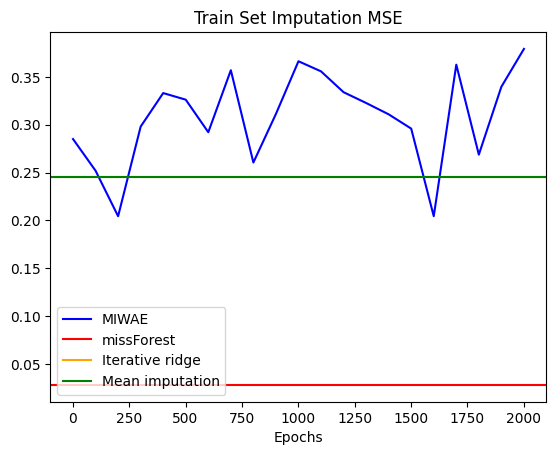

In [46]:
plt.plot(range(1,n_epochs,100),mse_train,color="blue")
plt.axhline(y=mse(xhat_mf_train, Xtrain, Xtrain_mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_ridge_train, Xtrain, Xtrain_mask),  linestyle='-',color="orange")
plt.axhline(y=mse(xhat_mean_train, Xtrain, Xtrain_mask),  linestyle='-',color="green")
plt.legend(["MIWAE","missForest","Iterative ridge", "Mean imputation"])
plt.title("Train Set Imputation MSE")
plt.xlabel("Epochs")
plt.show()